In [9]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from logger import Logger
from collector import Collector
from enricher import Enricher

In [10]:
# Inicialización de clases
logger = Logger()
df = pd.DataFrame()
logger.info('Main','main','Inicializar clase Logger')
collector = Collector(logger=logger)
enricher = Enricher(logger=logger)

In [13]:
df_1 = collector.collector_data()
df_2 = enricher.calcular_kpi(df_1)
df_2

c:\Users\PC\Documents\Proyecto Integrador V\PIV_2025-1\src\piv\collector.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')


,fecha,apertura,alto,bajo,cerrar,cierre_ajustado,volumen,dia,mes,año,retorno_diario,tasa_variacion_ac,retorno_acumulado,media_movil_5d,volatilidad
249,2024-05-24,467.62,479.85,466.30,478.22,476.48,12012300,24,Mayo,2024,0.000000,0.022668,0.000000,0.000,0.000000
248,2024-05-28,476.58,480.86,474.84,479.92,478.18,10175800,28,Mayo,2024,0.003555,0.007008,0.003555,0.000,0.000000
247,2024-05-29,474.66,479.85,473.70,474.36,472.64,9226200,29,Mayo,2024,-0.011585,-0.000632,-0.008072,0.000,0.000000
246,2024-05-30,471.67,471.73,464.71,467.05,465.35,10735200,30,Mayo,2024,-0.015410,-0.009795,-0.023357,0.000,0.000000
245,2024-05-31,465.80,469.12,454.46,466.83,465.13,16919800,31,Mayo,2024,-0.000471,0.002211,-0.023817,473.276,6.125253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-05-19,628.25,643.00,627.80,640.43,640.43,9592400,19,Mayo,2025,0.000141,0.019387,0.339195,648.008,9.034449
3,2025-05-20,636.01,639.35,632.26,637.10,637.10,6743500,20,Mayo,2025,-0.005200,0.001714,0.332232,644.222,8.795568
2,2025-05-21,631.79,646.61,630.17,635.50,635.50,11464600,21,Mayo,2025,-0.002511,0.005872,0.328886,639.450,3.259693
1,2025-05-22,634.05,643.25,630.71,636.57,636.57,8228400,22,Mayo,2025,0.001684,0.003974,0.331124,637.988,2.263000


In [14]:
df_2['fecha'] = pd.to_datetime(df_2['fecha'], errors='coerce')
df_2 = df_2.dropna(subset=['fecha', 'cierre_ajustado'])
df_2 = df_2[['fecha', 'cierre_ajustado']]
df_2 = df_2.set_index('fecha')
df_2 = df_2.sort_index()

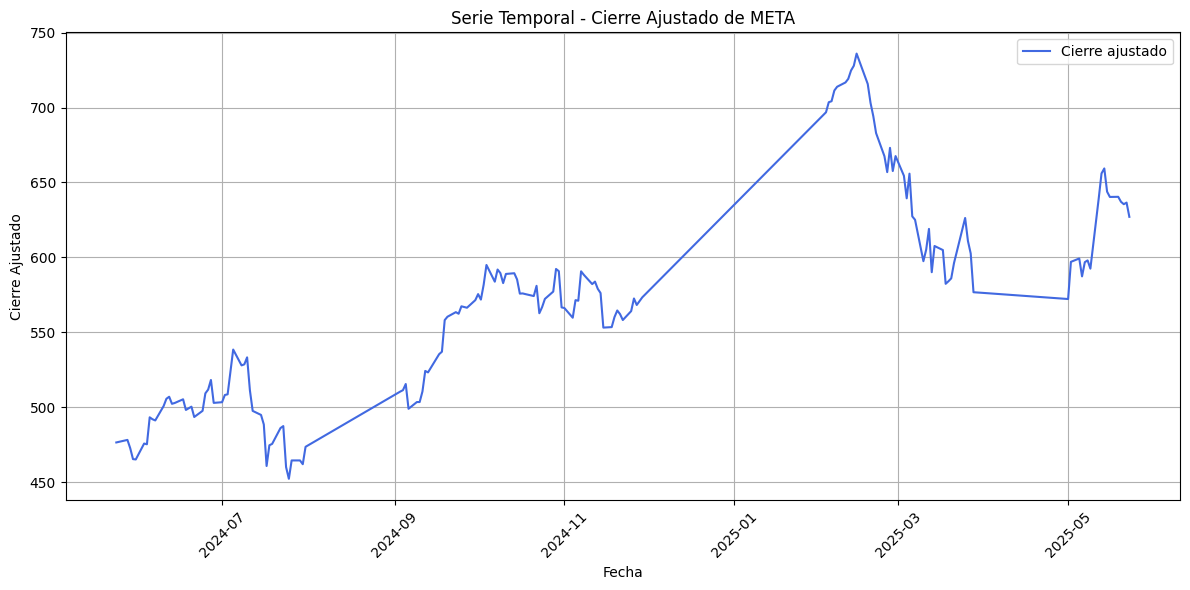

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df_2.index, df_2['cierre_ajustado'], label='Cierre ajustado', color='royalblue')
plt.title('Serie Temporal - Cierre Ajustado de META')
plt.xlabel('Fecha')
plt.ylabel('Cierre Ajustado')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

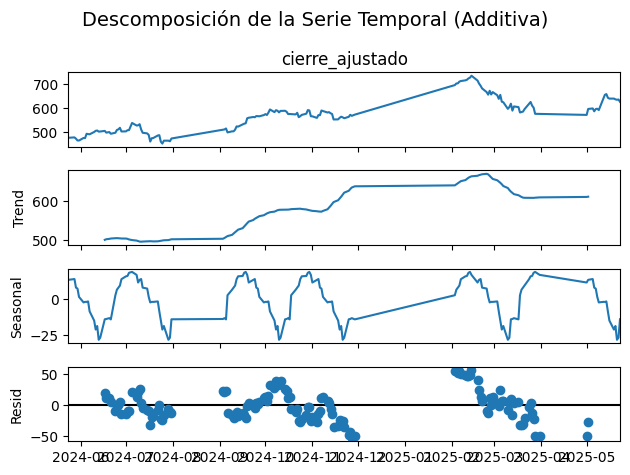

In [18]:
decomposition = seasonal_decompose(df_2['cierre_ajustado'], model='additive', period=30)
decomposition.plot()
plt.suptitle('Descomposición de la Serie Temporal (Additiva)', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
adf_result = adfuller(df_2['cierre_ajustado'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Valores críticos:", adf_result[4])
if adf_result[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")

ADF Statistic: -1.6496711969530558
p-value: 0.4572119109641259
Valores críticos: {'1%': np.float64(-3.470616369591229), '5%': np.float64(-2.8792214018977655), '10%': np.float64(-2.57619681359045)}
La serie no es estacionaria.


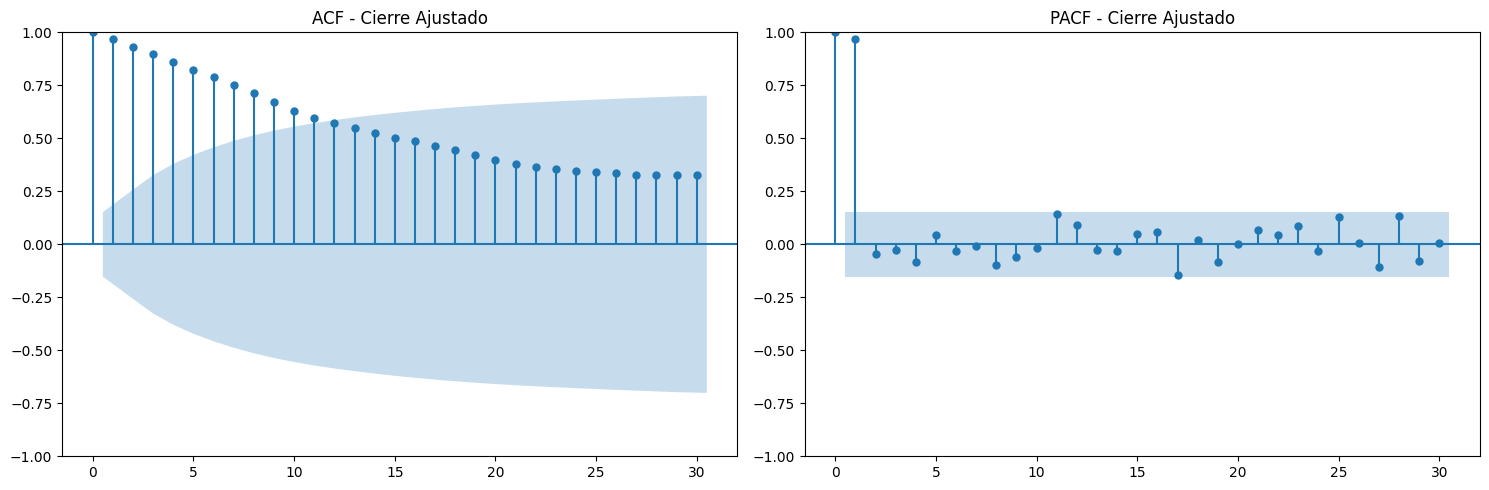

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df_2['cierre_ajustado'], ax=axes[0], lags=30)
plot_pacf(df_2['cierre_ajustado'], ax=axes[1], lags=30)
axes[0].set_title('ACF - Cierre Ajustado')
axes[1].set_title('PACF - Cierre Ajustado')
plt.tight_layout()
plt.show()

In [21]:
train = df_2['cierre_ajustado'].iloc[:-30]
test = df_2['cierre_ajustado'].iloc[-30:]

model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
forecast = model_fit.forecast(steps=30)
forecast.index = test.index

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [23]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

MAE: 23.4024
RMSE: 25.9013
R2 Score: -0.0649


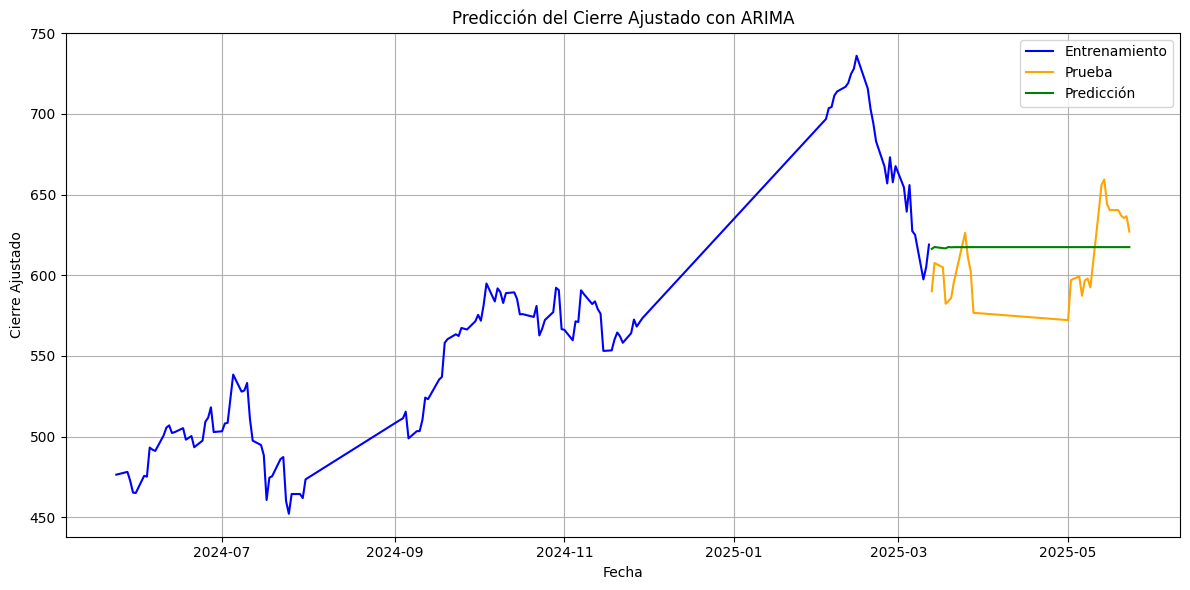

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='orange')
plt.plot(forecast.index, forecast, label='Predicción', color='green')
plt.title('Predicción del Cierre Ajustado con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Cierre Ajustado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()